# Running stardist in Krakatoa with a GPU

Based on jupyeter labs provided by stardist

Marcnol, UPDATED MAR 2022 for drosophila embryo cells

# Packages

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
import os
from glob import glob
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from matplotlib.pyplot import figure
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from PIL import Image
from csbdeep.utils import Path, normalize

### Check CUDA version and GPU

In [2]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:08:53_PST_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
Thu May  5 08:41:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   28C    P8    11W / 320W |      6MiB / 11178MiB |      0%      Default |
|                               |       

### Select which GPU to perfom the calculations on

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1" # OS environ is a list of variable in the working environment
#When changing CUDA VISIBLE you are hiding GPUs so in a way selecting the other (only works if you have 2 GPUs)


# Import the images

In [160]:
raw= np.load('Outputs/raw/scan_002_RT17_004_ROI_converted_decon_ch00_raw.npy')

print(raw.shape)

lab = np.load('Outputs/labeled/scan_002_RT17_004_ROI_converted_decon_ch00_mask.npy')

print(lab.shape)

(70, 2048, 2048)
(70, 2048, 2048)


### Porject the images to analyse faster

65535


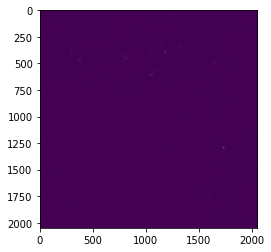

In [161]:
data = np.max(raw,axis=0)

plt.imshow(data)
print(np.max(data))

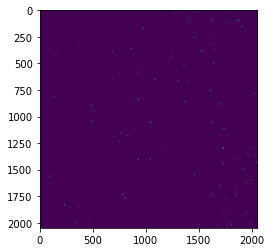

In [162]:
lab_moy = np.max(lab,axis = 0)
plt.imshow(lab_moy)

### Calculate stats for the detection

In [163]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))  


(88.74275758098501, 85.0, 27.666560872889345)


### Find the stars

## Function to call starfind multiple times by changing the parameters of the threshold

In [73]:
def findstars(p,data,fwhm,thresh=5.,sigma=3):
    
    mean, median, std = sigma_clipped_stats(data, sigma=sigma)  
    daofind = DAOStarFinder(fwhm=fwhm, threshold=thresh*std)  
    sources = daofind(data)  
    for col in sources.colnames:  
        sources[col].info.format = '%.8g'  # for consistent table output
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.)
    
    if type(p) == str() :
        
        norm = ImageNormalize(stretch=SqrtStretch())
        plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
               interpolation='nearest')
        apertures.plot(color='blue', lw=1.5, alpha=0.5)
        plt.show()
    
    return positions

In [74]:
m= findstars('t',data,5)

    

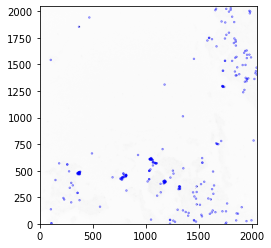

In [46]:
m = findstars(data,3)

In [164]:
d = data[0:250,1750:2048]
l = lab_moy[0:250,1750:2048]


m = findstars('ye',data,5,6)

crop_2 = []

counter = 0 

for i in m:

    x = round(list(i)[0])
    y = round(list(i)[1])
    
    if lab_moy[y,x] > 0 :
        counter +=1
        
print(counter)
    
#apertures = CircularAperture(m, r=4.) 

#figure(figsize=(30, 10))
#cmap= random_label_cmap()


#plt.imshow(l,cmap=cmap,origin = "lower")
#apertures.plot(color='blue', lw=1.5)

#plt.show()

92


In [165]:
len(m)

488

In [166]:
92/488

0.1885245901639344

In [105]:
counter = 0
test = 0
for i in m:
    
    x = round(list(i)[0])
    y = round(list(i)[1])
    
    if np.sum(lab_moy[x-2:x+2,y-2:y+2]) > 0:
        counter += 1
    test += 1
    
print(counter)
print(test)

7
684


In [117]:
len(m)

488

13


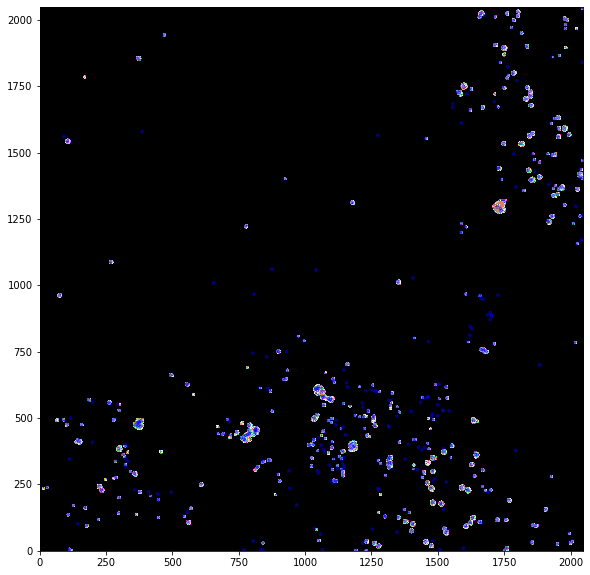

In [116]:
m = findstars('y',data,5,6)

crop_2 = []

counter = 0 
for i,j in zip(m,range(len(m))):
    crop_2.append(lab_moy[round(list(i)[0]-5):round(list(i)[0]+5),round(list(i)[1]-5):round(list(i)[1]+5)])
    if np.sum(crop_2[j]) > 0:
        counter += 1

print(counter)
    
apertures = CircularAperture(m, r=4.) 

figure(figsize=(30, 10))
cmap= random_label_cmap()

plt.imshow(lab_moy,origin="lower",cmap=cmap)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()


634907626.py (4): Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


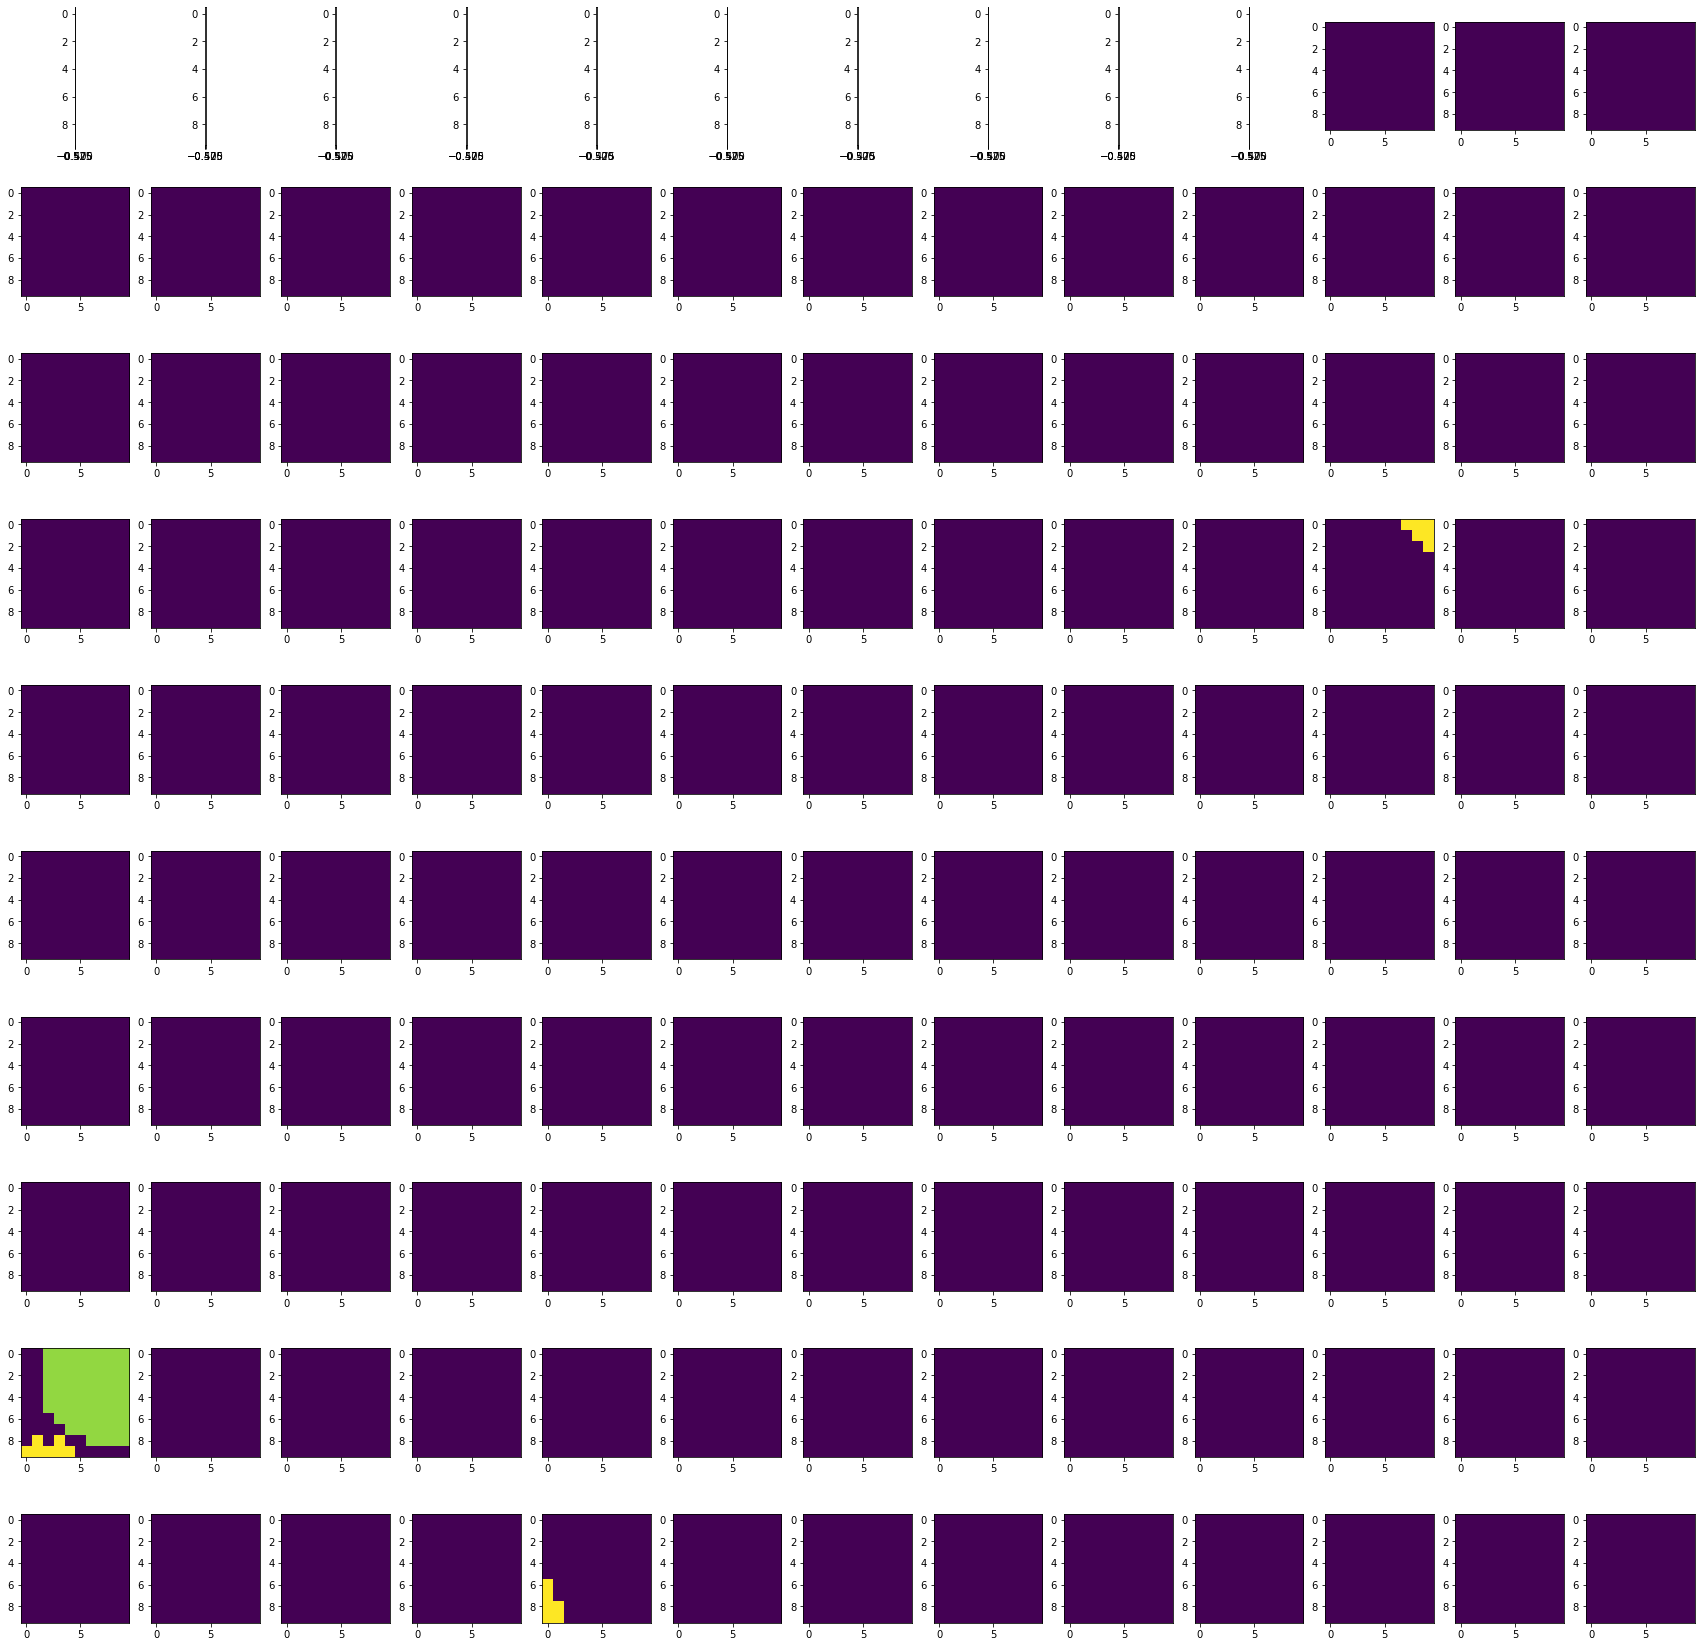

In [111]:
_, axs = plt.subplots(10, 13, figsize=(30, 30))
axs = axs.flatten()
for img, ax in zip(crop_2, axs):
    ax.imshow(img)
plt.show()

In [110]:
len(m)

684

In [107]:
np.max(lab_moy)

453

In [8]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid  sharpness  ... sky  peak    flux       mag    
--- --------- ---------- ---------- ... --- ----- --------- -----------
  1 1751.1003 0.61921276 0.73512329 ...   0  5851 27.940354  -3.6155798
  2 1228.0049 0.79073931 0.26292197 ...   0  1568 7.5617198  -2.1965515
  3 112.04646  2.8757753  0.4068613 ...   0   925 1.1130378 -0.11627482
  4 110.54635  5.4216338 0.46018449 ...   0   909 1.5270345  -0.4596221
  5 1757.9903  10.229315  0.4744352 ...   0  4073 19.719575  -3.2372439
  6 1275.3946  18.388416 0.46159598 ...   0  4124 16.259549  -3.0277713
  7 1472.9355  20.475746 0.45739714 ...   0  7165 32.882188  -3.7924018
...       ...        ...        ... ... ...   ...       ...         ...
248 1983.7254  1997.9242 0.44396441 ...   0   533 1.4835677 -0.42826839
249 1975.2371  2004.9471 0.44156728 ...   0  1308 3.7444476  -1.4334694
250 1655.0493   2011.553 0.50566108 ...   0  3005 14.596957  -2.9106558
251  1798.556   2013.869 0.48420932 ...   0  2902 12.535704  -2.

### Plot the detected object on the raw image

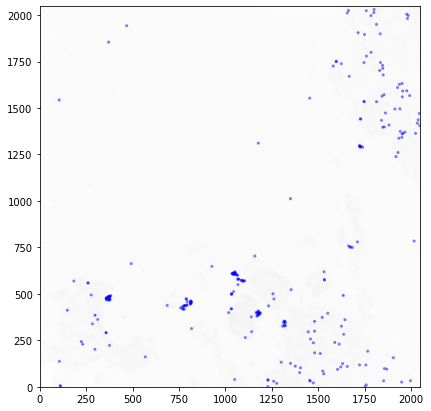

In [9]:
figure(figsize=(10, 7))

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

## Plot the detected object on the labeld image and the raw image 

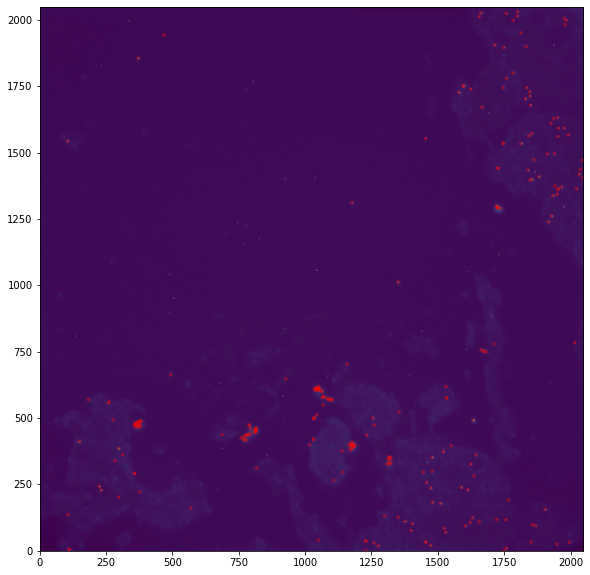

In [11]:
figure(figsize=(30, 10))
cmap= random_label_cmap()

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(lab_moy, origin='lower',
           interpolation='nearest',cmap=cmap)
plt.imshow(data, origin='lower',
           interpolation='nearest',norm=norm,alpha=0.9)
apertures.plot(color='red', lw=1.5, alpha=0.4)
#plt.savefig('Plots/RT17_StarfindvsStardistvsRaw_3.png',dpi=500)
plt.show()

# Going the other way around, starting from the labeled image and finiding the position in the raw image 

In [12]:
properties = ['label', 'area','centroid']

df = pd.DataFrame(regionprops_table(lab_moy,intensity_image=data,properties = properties))

pos = []
for i in df.index:
    pos.append(list(df.iloc[i, 2:]))

crop = []
for j in range(len(pos)):
    crop.append(data[round(pos[j][0]-10):round(pos[j][0]+10),round(pos[j][1]-10):round(pos[j][1]+10)])


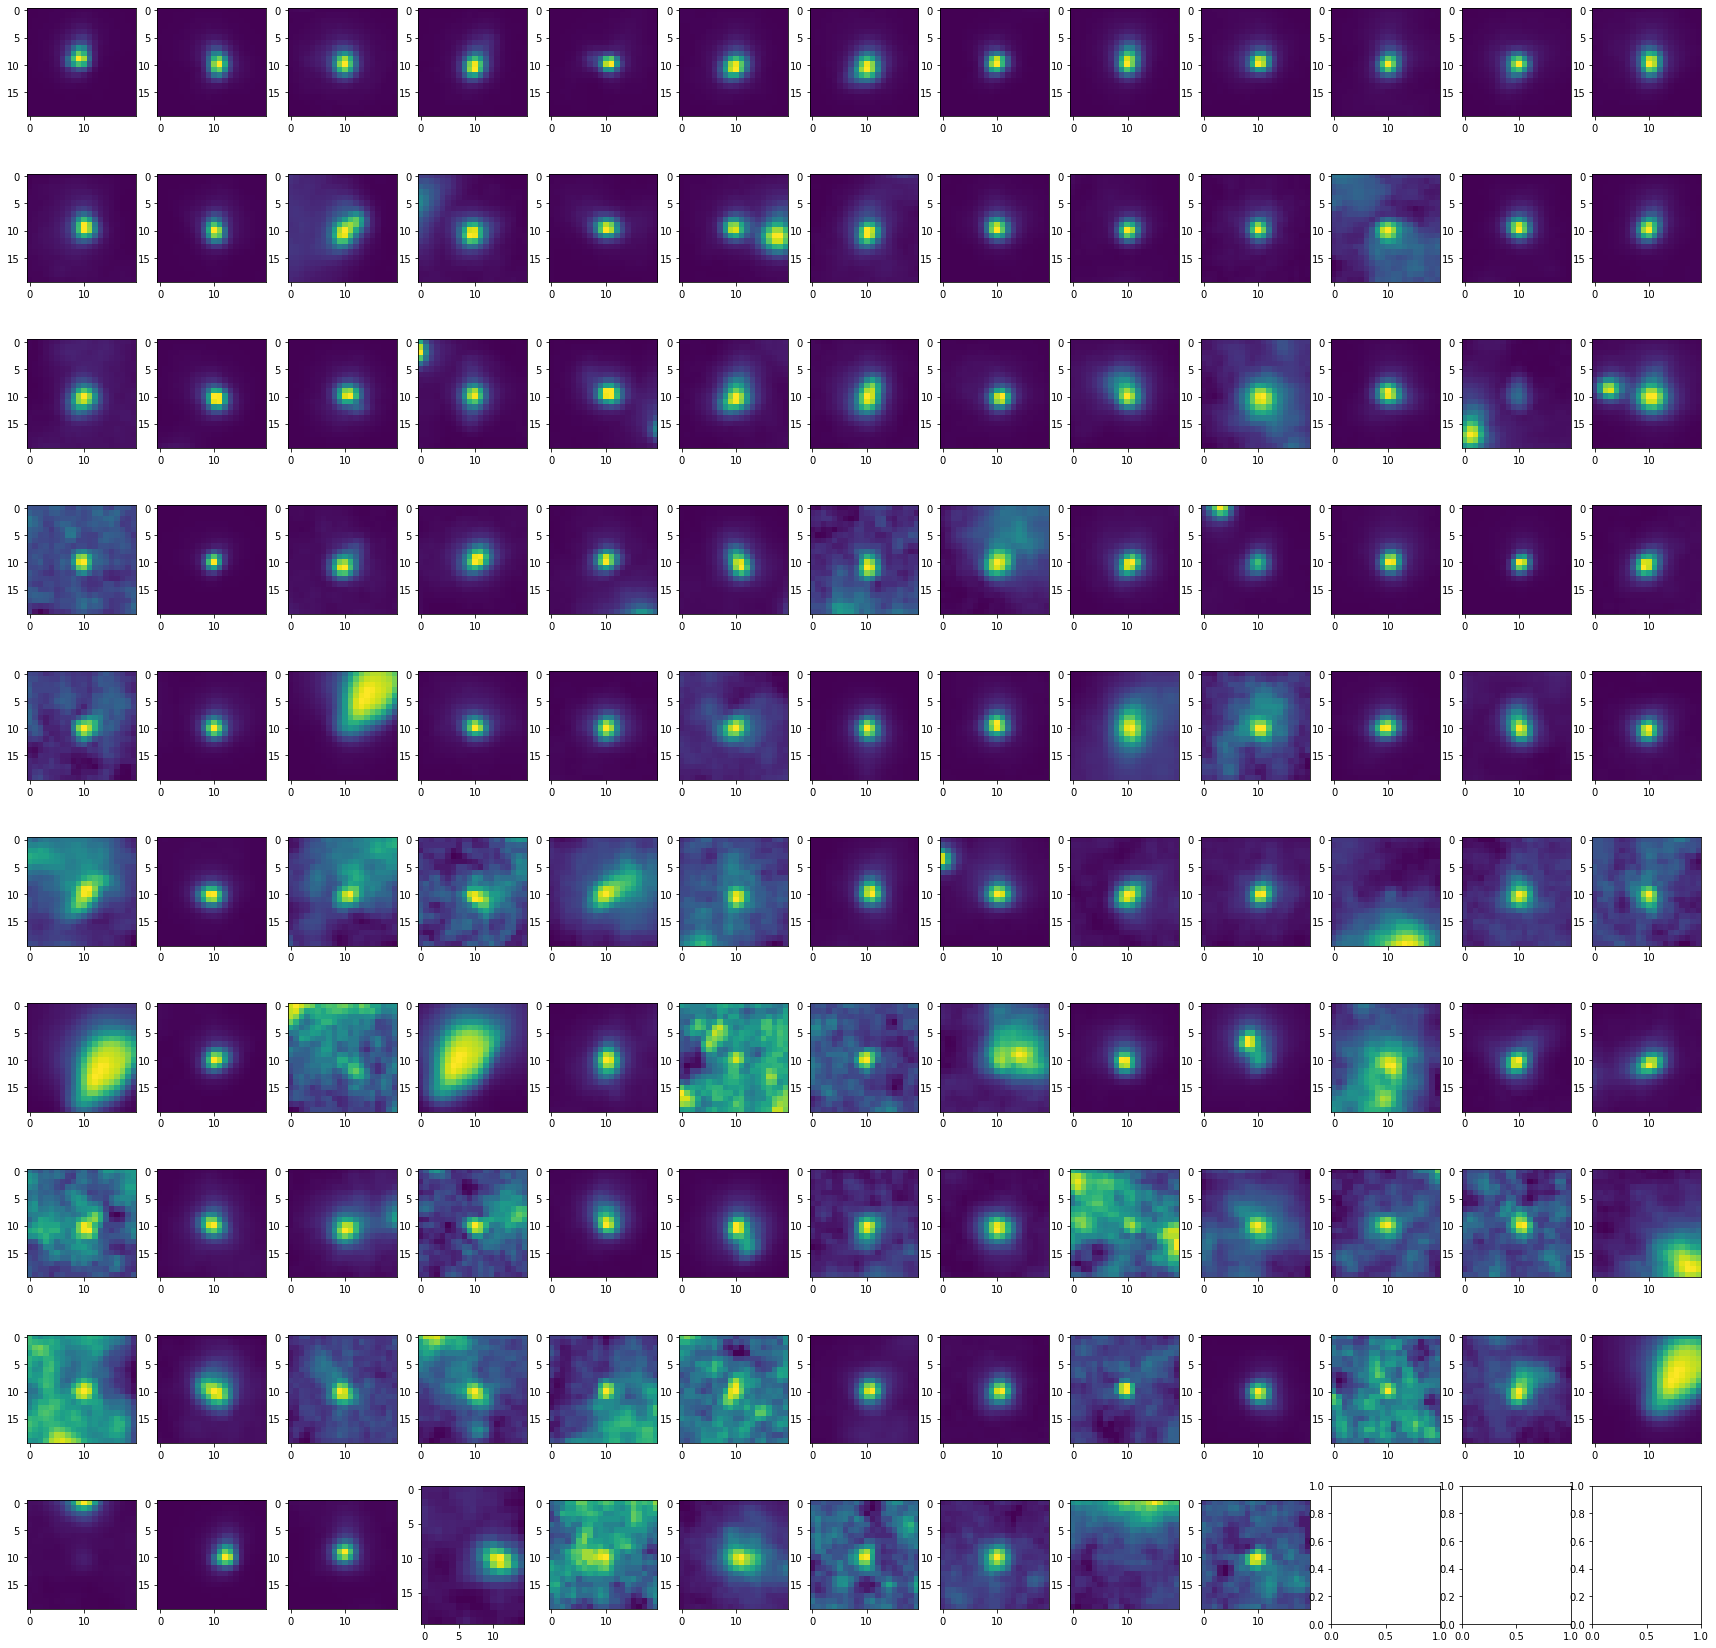

In [14]:
_, axs = plt.subplots(10, 13, figsize=(30, 30))
axs = axs.flatten()
for img, ax in zip(crop, axs):
    ax.imshow(img)
plt.show()

### Same thing but with a 3D image 

we can access the centroid coordinate in z so we could crop also the raw image in the z position and thus have really the centroid of the labeled image

In [184]:
properties = ['label', 'area','centroid_weighted']

df_2 = pd.DataFrame(regionprops_table(lab,intensity_image=raw,properties = properties))

pos_2 = []
for i in df_2.index:
    pos_2.append(list(df_2.iloc[i, 2:]))

crop_2 = []

for j in range(len(pos_2)):
    crop_2.append(raw[round(pos_2[j][0]),round(pos_2[j][1]-5):round(pos_2[j][1]+5),round(pos_2[j][2]-5):round(pos_2[j][2]+5)])



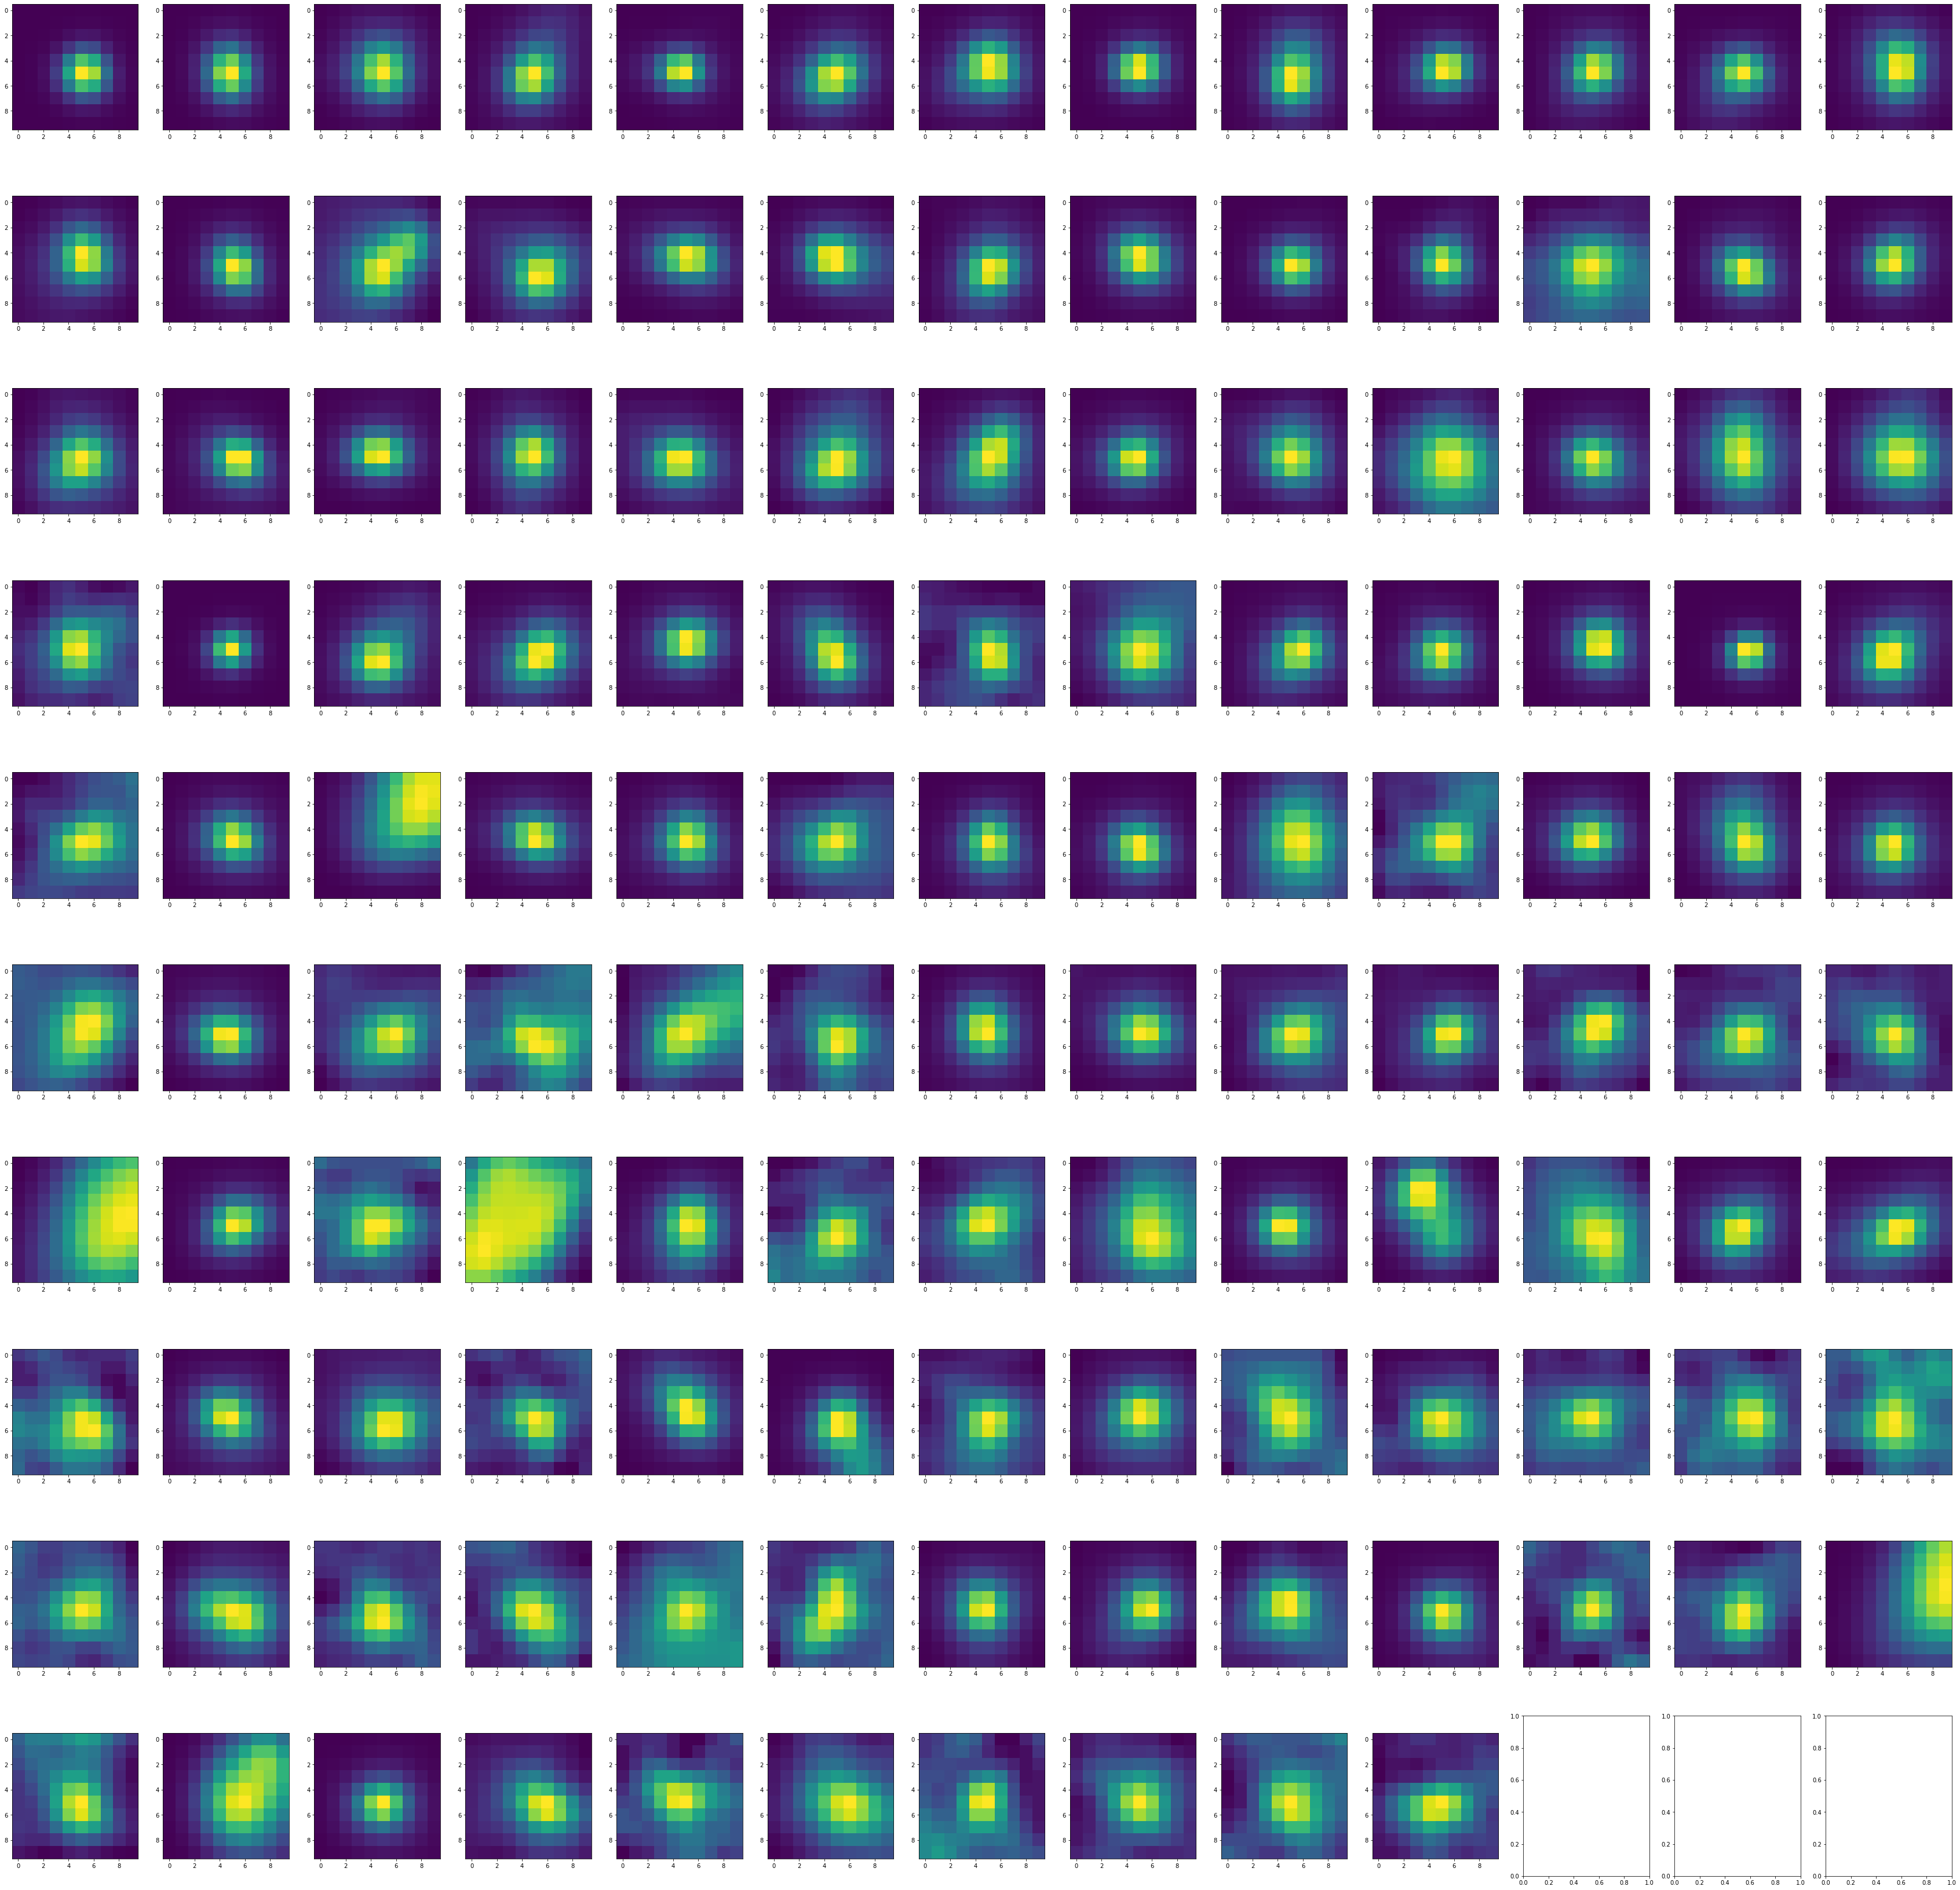

In [116]:
_, axs = plt.subplots(10, 13, figsize=(60, 60))
axs = axs.flatten()
for img, ax in zip(crop_2, axs):
    ax.imshow(img)
plt.show()

#### Sort the list of images based on intensities

proof of concept: if sorted then the max per image will also be sorted : 

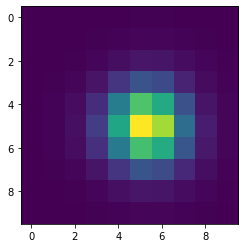

In [163]:
test = crop_2 

matrice = []
for i in range(len(test[:])):
    matrice.append([test[i],np.max(test[i])])
    
matrice_s = sorted(matrice, key=lambda m: m[1],reverse=True)

matrice_f = []

for i in range(len(matrice_s)):
    matrice_f.append(matrice_s[i][0])



In [137]:
matrice = []
for i in range(len(test[:])):
    matrice.append([test[i],np.max(test[i])])
    
matrice_s = sorted(matrice, key=lambda m: m[1],reverse=True)

matrice_s

[[array([[   59,    77,   109,   171,   268,   353,   364,   292,   189,
            113],
         [   86,   123,   199,   375,   696,  1018,  1058,   774,   424,
            204],
         [  131,   223,   443,  1068,  2462,  3949,  3796,  2224,   932,
            355],
         [  189,   401,  1059,  3441,  9885, 16908, 14699,  6668,  2006,
            583],
         [  236,   611,  2106,  8617, 27650, 47470, 40064, 16233,  3857,
            880],
         [  246,   701,  2745, 12078, 38829, 65535, 56518, 23493,  5360,
           1128],
         [  216,   592,  2175,  8813, 27054, 46116, 40429, 17620,  4512,
           1086],
         [  165,   397,  1189,  3857, 10251, 16960, 15156,  7298,  2364,
            756],
         [  113,   233,   549,  1332,  2781,  4123,  3798,  2192,   961,
            424],
         [   73,   130,   248,   462,   752,   965,   910,   640,   378,
            221]], dtype=uint16),
  65535],
 [array([[  304,   414,   595,   828,  1027,  1043,   855,   613

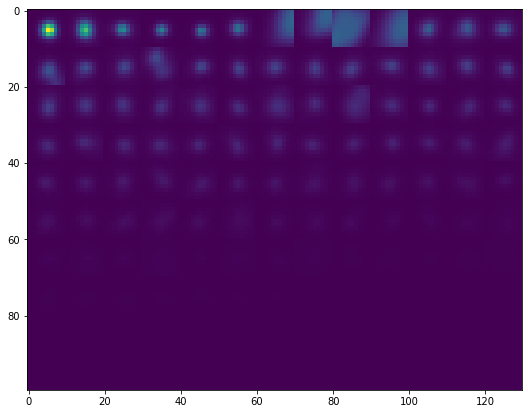

In [164]:
test = crop_2

matrice = []

for i in range(len(test[:])):
    matrice.append([test[i],np.max(test[i])])
    
matrice_s = sorted(matrice, key=lambda m: m[1],reverse=True)

matrice_f = []

for i in range(len(matrice_s)):
    matrice_f.append(matrice_s[i][0])
    

images = [Image.fromarray(x) for x in matrice_f]

new_im = Image.new('I;16', (130,100))

x = 0 
y = 0
j = 0

while j<len(images):
    for k in range(13):
        if j+k<len(images):
            new_im.paste(images[j+k], (x+k*10,y))
        else: break 
    y += 10
    j += 13
    
figure(figsize=(10, 7)) 

plt.imshow(new_im)
plt.show()

# Doesn't work 

In [187]:
crop_2[0].astype('float')

array([[5.9000e+01, 7.7000e+01, 1.0900e+02, 1.7100e+02, 2.6800e+02,
        3.5300e+02, 3.6400e+02, 2.9200e+02, 1.8900e+02, 1.1300e+02],
       [8.6000e+01, 1.2300e+02, 1.9900e+02, 3.7500e+02, 6.9600e+02,
        1.0180e+03, 1.0580e+03, 7.7400e+02, 4.2400e+02, 2.0400e+02],
       [1.3100e+02, 2.2300e+02, 4.4300e+02, 1.0680e+03, 2.4620e+03,
        3.9490e+03, 3.7960e+03, 2.2240e+03, 9.3200e+02, 3.5500e+02],
       [1.8900e+02, 4.0100e+02, 1.0590e+03, 3.4410e+03, 9.8850e+03,
        1.6908e+04, 1.4699e+04, 6.6680e+03, 2.0060e+03, 5.8300e+02],
       [2.3600e+02, 6.1100e+02, 2.1060e+03, 8.6170e+03, 2.7650e+04,
        4.7470e+04, 4.0064e+04, 1.6233e+04, 3.8570e+03, 8.8000e+02],
       [2.4600e+02, 7.0100e+02, 2.7450e+03, 1.2078e+04, 3.8829e+04,
        6.5535e+04, 5.6518e+04, 2.3493e+04, 5.3600e+03, 1.1280e+03],
       [2.1600e+02, 5.9200e+02, 2.1750e+03, 8.8130e+03, 2.7054e+04,
        4.6116e+04, 4.0429e+04, 1.7620e+04, 4.5120e+03, 1.0860e+03],
       [1.6500e+02, 3.9700e+02, 1.1890e+0

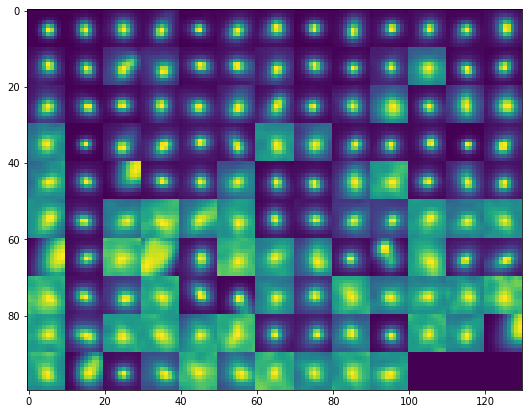

In [189]:
figure(figsize=(10, 7))

'''
axis_norm=(0, 1)

for i in range(len(crop_2)):
    
    crop_2[i] = normalize(crop_2[i],1,99.8,axis=axis_norm)
'''


for i in range(len(crop_2)):
    
    crop_2[i].astype('float')
    
    crop_2[i] = crop_2[i]/np.max(crop_2[i])*100


images = [Image.fromarray(x) for x in crop_2]

new_im = Image.new('I;16', (130,100))

x = 0 
y = 0
j = 0

while j<len(images):
    for k in range(13):
        if j+k<len(images):
            new_im.paste(images[j+k], (x+k*10,y))
        else: break 
    y += 10
    j += 13
plt.imshow(new_im)
plt.show()


# Functions for automated pipeline

## 1. Gallery creation

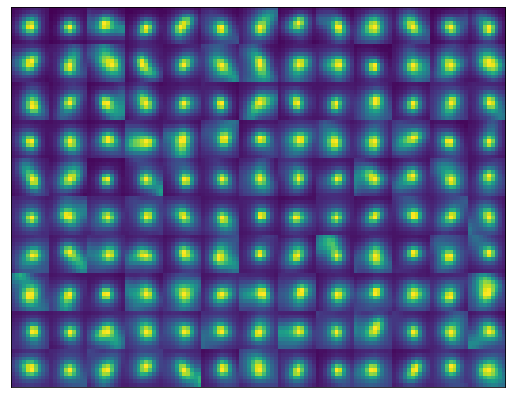

In [4]:
raw= np.load('Outputs/raw/data_christophe/untouched/scan_002_RT40_001_ROI_converted_decon_ch00_raw.npy')


lab = np.load('Outputs/labeled/data_christophe/retrained_network/scan_002_RT40_001_ROI_converted_decon_ch00_mask.npy')

def gallery(lab,raw,r):
    
    properties = ['label', 'centroid_weighted']

    df = pd.DataFrame(regionprops_table(lab,intensity_image=raw,properties = properties))

    pos = []
    
    for i in df.index:
        pos.append(list(df.iloc[i, 1:]))

    crop = []

    for j in range(len(pos)):
        crop.append(raw[round(pos[j][0]),round(pos[j][1]-r):round(pos[j][1]+r),round(pos[j][2]-r):round(pos[j][2]+r)])

    matrice = []

    for k in range(len(crop[:])):
        matrice.append([crop[k],np.max(crop[k])])

    matrice_s = sorted(matrice, key=lambda m: m[1],reverse=True)

    matrice_f = []

    for l in range(len(matrice_s)):
        matrice_f.append(matrice_s[l][0])
    
    for o in range(len(matrice_f)):
    
        matrice_f[o].astype('float')

        matrice_f[o] = matrice_f[o]/np.max(matrice_f[o])*100
    
    images = [Image.fromarray(x) for x in matrice_f]

    new_im = Image.new('I;16', (130,100))

    x = 0 
    y = 0
    m = 0

    while m<len(images):
        for n in range(13):
            if m+n<len(images):
                new_im.paste(images[m+n], (x+n*10,y))
            else: break 
        y += 10
        m += 13
    
    figure(figsize=(10, 7))
    plt.imshow(new_im)
    plt.xticks([])
    plt.yticks([])
    #plt.show()


g = gallery(lab,raw,5)

#plt.savefig('Plots/gallery_retrained.png',dpi = 400)

### Still needs to be sorted by increasing intensity and normalization

In [121]:
test = crop_2
test[0]

array([[   59,    77,   109,   171,   268,   353,   364,   292,   189,
          113],
       [   86,   123,   199,   375,   696,  1018,  1058,   774,   424,
          204],
       [  131,   223,   443,  1068,  2462,  3949,  3796,  2224,   932,
          355],
       [  189,   401,  1059,  3441,  9885, 16908, 14699,  6668,  2006,
          583],
       [  236,   611,  2106,  8617, 27650, 47470, 40064, 16233,  3857,
          880],
       [  246,   701,  2745, 12078, 38829, 65535, 56518, 23493,  5360,
         1128],
       [  216,   592,  2175,  8813, 27054, 46116, 40429, 17620,  4512,
         1086],
       [  165,   397,  1189,  3857, 10251, 16960, 15156,  7298,  2364,
          756],
       [  113,   233,   549,  1332,  2781,  4123,  3798,  2192,   961,
          424],
       [   73,   130,   248,   462,   752,   965,   910,   640,   378,
          221]], dtype=uint16)